In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.model_selection import train_test_split 
import nltk 
import joblib
import string
import re
from flask import Flask
from flask import request
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/derickrentz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/derickrentz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset
def load_data():
    data = pd.read_csv('gold_reddit_corpus_agree.csv')
    return data

In [3]:
reddit_df = load_data()

<AxesSubplot:xlabel='cls', ylabel='count'>

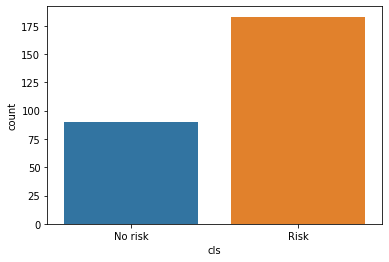

In [4]:
sns.countplot(x = 'cls', data = reddit_df)

In [5]:
df = pd.DataFrame(reddit_df[['text']])
df

,text
0,Insert random platitude here.
1,It's like this in Canada. Don't ever call a helpline. Their thereshold for calling the cops is p...
2,It has never occured to me before now that this also a method of suicide (although this was a fl...
3,"Obese people, regardless of their gender, make me shit."
4,The best way to spot a hyper-macho is knowing how much you love your mother. The most dangerous ...
...,...
268,I'm gonna end it all\nEverything is getting worse and worse. My parents value material things mo...
269,757 ppl online\nits comforting to know that theres ppl other than me who feel this way but why a...
270,"I've meticulously planned everything to the last detail, but whenever they ask me if I have a pl..."
271,"Fuck me\nI just want to go to sleep, and never wake up"


In [6]:
def clean_text(text):
    ps = nltk.PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    stopword.extend(['http', 'https'])
    
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [7]:
tfidfconverter = TfidfVectorizer(analyzer=clean_text, max_features=350)  
X = tfidfconverter.fit_transform(df['text'])
print('{} Number of texts has {} words'.format(X.shape[0], X.shape[1]))

273 Number of texts has 350 words


In [8]:
count_vect_df = pd.DataFrame(X.toarray(), columns=tfidfconverter.get_feature_names())
count_vect_df.head(100)

,,abl,absolut,accept,act,actual,age,ago,aliv,almost,...,worthless,would,wouldnt,write,wrong,xb,year,yet,young,your
0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.261836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.258839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.433422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.263620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Getting cls column
y = pd.DataFrame(reddit_df['cls']).values.ravel()
# y = y.values.ravel()

# Splitting train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

risk_count = 0
no_risk_count = 0

# Prints training data split
for i in y_train:
    if i == 'Risk':
        risk_count += 1
    else:
        no_risk_count += 1

print ("Risk: ", risk_count)
print ("No risk: ", no_risk_count)

Risk:  142
No risk:  76


In [10]:
# Training the model with training data
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [11]:
# Doing predictions with test data
predictions = text_classifier.predict(X_test)
predictions_proba = text_classifier.predict_proba(X_test)

print (predictions)
print (predictions_proba)

['Risk' 'Risk' 'Risk' 'Risk' 'Risk' 'Risk' 'No risk' 'Risk' 'No risk'
 'Risk' 'Risk' 'Risk' 'Risk' 'Risk' 'No risk' 'Risk' 'No risk' 'Risk'
 'Risk' 'Risk' 'No risk' 'Risk' 'No risk' 'Risk' 'No risk' 'No risk'
 'No risk' 'Risk' 'Risk' 'Risk' 'Risk' 'Risk' 'Risk' 'Risk' 'No risk'
 'Risk' 'Risk' 'No risk' 'No risk' 'Risk' 'No risk' 'Risk' 'Risk' 'Risk'
 'No risk' 'Risk' 'Risk' 'Risk' 'Risk' 'No risk' 'Risk' 'Risk' 'Risk'
 'Risk' 'Risk']
[[0.3  0.7 ]
 [0.36 0.64]
 [0.22 0.78]
 [0.15 0.85]
 [0.17 0.83]
 [0.13 0.87]
 [0.82 0.18]
 [0.23 0.77]
 [0.52 0.48]
 [0.17 0.83]
 [0.37 0.63]
 [0.19 0.81]
 [0.2  0.8 ]
 [0.11 0.89]
 [0.78 0.22]
 [0.16 0.84]
 [0.51 0.49]
 [0.19 0.81]
 [0.2  0.8 ]
 [0.29 0.71]
 [0.91 0.09]
 [0.19 0.81]
 [0.53 0.47]
 [0.25 0.75]
 [0.51 0.49]
 [0.99 0.01]
 [0.74 0.26]
 [0.19 0.81]
 [0.47 0.53]
 [0.25 0.75]
 [0.2  0.8 ]
 [0.08 0.92]
 [0.08 0.92]
 [0.14 0.86]
 [0.86 0.14]
 [0.22 0.78]
 [0.23 0.77]
 [0.93 0.07]
 [0.9  0.1 ]
 [0.22 0.78]
 [0.5  0.5 ]
 [0.32 0.68]
 [0.46 0.54]
 [0

In [12]:
risk_probas = []
# Probability >= 95%
black_flags = []
# Probability > 85% and < 95%
red_flags = []
# Probability > 70% and < 85%
orange_flags = []
#Probability > 50% and < 70%
yellow_flags = []

for i in predictions_proba:
    if i[1] > [0]:
        risk_probas.append(i[1])
        
for i in risk_probas:
    if i >= 0.95:
        black_flags.append(i)
    elif i >= 0.85:
        red_flags.append(i)
    elif i >= 0.70:
        orange_flags.append(i)
    else:
        yellow_flags.append(i)
        
print ("Black flags: " + str(len(black_flags)))
print ("Red flags: " + str(len(red_flags)))
print ("Orange flags: " + str(len(orange_flags)))
print ("Yellow flags: " + str(len(yellow_flags)))

Black flags: 0
Red flags: 7
Orange flags: 27
Yellow flags: 20


In [13]:
# Printing model metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

[[11  3]
 [ 4 37]]
              precision    recall  f1-score   support

     No risk       0.73      0.79      0.76        14
        Risk       0.93      0.90      0.91        41

    accuracy                           0.87        55
   macro avg       0.83      0.84      0.84        55
weighted avg       0.88      0.87      0.87        55

0.8727272727272727


In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

# Instantiate the grid search model
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)
# {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}

best_random = rf_random.best_estimator_

best_random_predictions = best_random.predict(X_test)

# Printing best random model metrics

print(confusion_matrix(y_test,best_random_predictions))  
print(classification_report(y_test,best_random_predictions))  
print(accuracy_score(y_test, best_random_predictions))

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

param_grid = {
    'n_estimators': [300,400,500,600,800,100], 
    'min_samples_split': [3,5,7], 
    'min_samples_leaf': [1,2,3], 
    'max_features': ['sqrt'], 
    'max_depth': [40,50,60,70,80], 
    'bootstrap': [False]
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_
best_grid = grid_search.best_estimator_

best_grid_predictions = best_grid.predict(X_test)

print(confusion_matrix(y_test,best_grid_predictions))  
print(classification_report(y_test,best_grid_predictions))  
print(accuracy_score(y_test, best_grid_predictions))

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False}
[[10  4]
 [ 2 39]]
              precision    recall  f1-score   support

     No risk       0.83      0.71      0.77        14
        Risk       0.91      0.95      0.93        41

    accuracy                           0.89        55
   macro avg       0.87      0.83      0.85        55
weighted avg       0.89      0.89      0.89        55

0.8909090909090909
Fitting 3 folds for each of 270 candidates, totalling 810 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   1.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=True, max_depth=10

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   1.8s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=False, max_depth=20

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   2.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   1.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.9s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=   1.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   1.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   1.2s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth

In [45]:
# Feature importances

featureImp = pd.Series(text_classifier.feature_importances_, tfidfconverter.get_feature_names()).sort_values(ascending=False)
print(featureImp.head(50))

featureImp = pd.Series(best_random.feature_importances_,index=tfidfconverter.get_feature_names()).sort_values(ascending=False)
print(featureImp.head(50))

im         0.034668
kill       0.033336
feel       0.026012
           0.025788
want       0.025417
time       0.023277
life       0.020614
get        0.019980
like       0.019560
die        0.019043
tell       0.016401
suicid     0.016280
tri        0.015268
dead       0.014549
thing      0.013408
go         0.013016
year       0.012402
anymor     0.012348
even       0.012303
live       0.011637
depress    0.011156
peopl      0.010036
wish       0.009958
attempt    0.009598
dont       0.009341
someon     0.009060
everi      0.008729
anyth      0.008068
parent     0.007973
hour       0.007550
one        0.007254
enough     0.007185
better     0.006931
noth       0.006737
make       0.006691
never      0.006617
ever       0.006507
would      0.006435
help       0.005823
cant       0.005582
probabl    0.005426
fuck       0.005369
could      0.005302
support    0.005159
come       0.005109
day        0.005098
still      0.005087
sleep      0.005074
post       0.005027
work       0.004989


In [ ]:
app = Flask(__name__)
@app.route('/classify', methods=['POST'])
def classifyText():
    text = request.json['text']
    vect_message = tfidfconverter.transform([text])

    classification = best_grid.predict(vect_message)[0]
    classification_proba = best_grid.predict_proba(vect_message)[0]
    probability = classification_proba[0] if (classification_proba[0] > classification_proba[1]) else classification_proba[1]
    
    response = classification + ": " + str(probability)
    print (text + ": " + response)
    return response

if __name__=="__main__":
    app.run()